<a href="https://colab.research.google.com/github/Hannah1123/UTS_ML2019_ID13135684/blob/master/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
  import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

#encoder-decoder 框架

In [0]:
class EncoderDecoder(nn.Module):
  """
  标准Encoder-Decoder架构 enbed: 嵌入 src: source tgt: target
  nn.module:神经网络模块化接口
  """
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator
  
  def forward(self, src, tgt, src_mask, tgt_mask):
    """
    接收并处理屏蔽的source和target序列。
    """
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
  
  def encode(self, src, src_mask):
    return self.encoder(self.src_embed(src), src_mask)
    
  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [0]:
class Generator(nn.Module):
  """
  定义标准线性和softmax
  """
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim= -1)

In [0]:
"""
encoder 由N=6个完全相同的层堆叠。
1、copy.copy 浅拷贝 只拷贝父对象，不会拷贝对象的内部的子对象。
2、copy.deepcopy 深拷贝 拷贝对象及其子对象: 即将被复制对象完全再复制一遍作为独立的新个体单独存在。所以改变原有被复制对象不会对已经复制出来的新对象产生影响。 

生成N个完全相同的层：
"""
def clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

#Encoder

主encoder是一个N层的堆叠  
为什么clones放在class encoder外面？ ：Encoder和Decoder都会用到这个clones  
LayerNorm 归一化？

In [0]:
class Encoder(nn.Module):
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    """
    依次使input（和mask）通过每个layer。
    """
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)


 residual connection： 残差连接，输入和输出相加，作为下一层的输入。  
 dense connection： 把所有层都与其他所有层相连，也就是说N层的网络，会有N*(N-1)/2个连接。用于减少计算量。densenet就同时做了两件事情，一是将网络中的每一层都直接与其前面层相连，提高特征的利用率；二是把网络的每一层设计得很窄，也就是卷积的输出通道数通常很小，只有几十，该层学习非常少的特征图并与输入concat使用。

In [0]:
class LayerNorm(nn.Module):
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim = True)
    std = x.std(-1, keepdim = True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

每个子层的输出为LayerNorm(x + Sublayer(x))，其中Sublayer(x）为每个子层完成的function。  
We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.  
为了方便残差连接，所有子层和嵌入层的输出维度为d=512

In [0]:
class SublayerConnection(nn.Module):
  def __init__(self, size, dropout):
    """
    一个残差连接之后接一个Layer norm 归一化
    """
    super(SuperlayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    """应用 残差连接 到所有有相同size的子层"""
    return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed- forward network.  
encoder由selt-attn 和 feed forward（前馈） 组成  
  

  lambda: 函数表达式


In [0]:
class EncoderLayer(nn.Module):
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    """根据figure 1 的左边来连接"""
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

#Decoder

Decoder 也是由 N=6 个完全相同的层堆叠  


In [0]:
class Decoder(nn.Module):
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

in addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization  
加入第三个子层 对encoder的堆叠 multi-head 注意。和encoder一样，每个子层有残差连接 并加上layer norm 归一化

In [0]:
class DecoderLayer(nn.Module):
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_sttn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size,dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)


We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  
确保位置i的输出只受已知位置（位置i之前）的输出的影响，加入一个子层mask

In [0]:
def subsequent_mask(size):
    "确定后续的位置."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0
    #torch.from_numpy:转换格式

In [0]:
np.ones((1, 20, 20))

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [1

In [0]:
np.triu(np.ones((1,20,20)), k=1)

array([[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1.],
        [0

In [0]:
np.triu(np.ones((1,20,20)), k=1).astype('uint8')

array([[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0,

figure语法说明

figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True)
*   num: 图像编号或名称，数字为编号 ，字符串为名称
*   figsize: 指定figure的宽和高，单位为英寸；  
*   dpi 参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
*   facecolor: 背景颜色
*   edgecolor: 边框颜色
*   frameon: 是否显示边框


<Figure size 360x360 with 0 Axes>

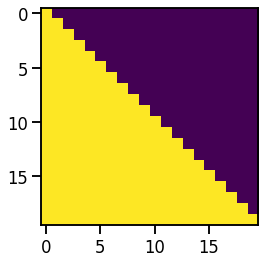

In [0]:
plt.figure(figsize=(5,5))
plt.show()
plt.imshow(subsequent_mask(20)[0])
None

#attention  
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.  
attention机制由 query，key，value三个向量组成。输出是values的加权总和，权重由query和相应的key确定

We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

将当前词作为搜索的query，去和句子中所有词（包含该词本身）的key去匹配，看看相关度有多高  
我们分别得到了Q1 与 K1,K2 的点乘积，然后我们进行尺度缩放与softmax归一化,得到attention score  
在用这些attention score与value vector相乘，得到加权的向量

In [0]:
def attention(quary, key, value, mask=None, dropout=None):
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  #matmul：高维向量乘法  transpose：转置 为什么要转置？？
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = F.softmax(scores, dim = -1) 
  # dim=0表示按列计算；dim=1表示按行计算，dim=-1,即,以最后一个维度作为一维向量计算softmax
  if dropout is not None:
    p_attn = dropout(p_attn)
  return torch.matmul(p_atten, value), p_attn


而multihead就是我们可以有不同的Q,K,V表示，最后再将其结果结合起来

In [0]:
class MultiHeadedAttention(nn.Module):
  def __init__(self, h, d_model, dropout=0.1):
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0 
    #假设 d_v 永远等于 d_k ???
    self.d_k = d_model // h  #减少维度使总计算量相当于single-head用全维度计算 512/8=64维
    self.h = h   #取h=8
    self.attn = None
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    if mask is not None:
      #同一个mask 用于所有h head
      mask = mask.unsqueeze(1) #在1的位置加入维度为1的维度，如原来为（4，3），就变为（4，1，3） 
    nbatches = query.size(0)  #0维上的元素个数
  
    "1）线性投影 从d_model到 h*d_k"
    query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
                 # view（）函数：重塑张量维形状(nbatches, -1, self.h, self.d_k)，（-1表示未知，由计算机自己算），之后 转置（1，2）

    "2）应用attention到投影向量上"
    x, self.attn = attention(query, key, value, mask=mask, dropout = self.dropout)

    "3）"Concat" using a view and apply a final linear. "
    x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h*self.d_k)
    return self.linears[-1](x)
    

unsqueeze用法：  
torch.squeeze() 这个函数主要对数据的维度进行压缩，去掉维数为1的的维度，比如是一行或者一列这种，一个一行三列（1,3）的数去掉第一个维数为一的维度之后就变成（3）行。squeeze(a)就是将a中所有为1的维度删掉。不为1的维度没有影响。a.squeeze(N) 就是去掉a中指定的维数为一的维度。还有一种形式就是b=torch.squeeze(a，N) a中去掉指定的定的维数为一的维度。

再看torch.unsqueeze()这个函数主要是对数据维度进行扩充。给指定位置加上维数为一的维度，比如原本有个三行的数据（3），在0的位置加了一维就变成一行三列（1,3）。a.squeeze(N) 就是在a中指定位置N加上一个维数为1的维度。还有一种形式就是b=torch.squeeze(a，N) a就是在a中指定位置N加上一个维数为1的维度  
torch.squeeze(input, dim=None, out=None) → Tensor  
dim指定维度


**向量的点乘为什么要使用投影？**

#Applications of Attention in our Model  
 1）“encoder-decoder attention” layers, Q从之前的decoder得来，而K和V由encoder得来。这允许decoder中的每个位置都参与输入序列中的所有位置。这模仿了seq2seq模型中的典型encoder-decoder注意机制。  
 2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot- product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.